In [3]:
import numpy as np
from graphviz import Digraph
from warnings import warn


In [4]:
GPU_AVAIL = True
try:
    import cupy as cp
except:
    GPU_AVAIL = False
    warn("GPU (cupy) not available. Falling back to CPU (numpy) computations.")


/tmp/ipykernel_70679/2353820950.py:6: UserWarning: GPU (cupy) not available. Falling back to CPU (numpy) computations.
  warn("GPU (cupy) not available. Falling back to CPU (numpy) computations.")


In [5]:
def _truncate_string(s, max_length):
    if len(s) > max_length:
        return s[: max_length - 3] + "..."  # truncate and add ellipsis
    return s


def _trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_graph(root, max_data_length=50):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = _trace(root)
    for n in nodes:
        uid = str(id(n))
        label_data = _truncate_string(repr(n.data), max_data_length)
        label_grad = _truncate_string(repr(n.grad), max_data_length)
        dot.node(
            name=uid,
            label="{ %s | data %s | grad %s }" % (n.label, label_data, label_grad),
            shape="record",
        )
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


def _broadcast_axis(shape_left, shape_right):
    """
    Determine the axes along which broadcasting occurs between two shapes.

    Args:
        shape_left: Shape of the left tensor.
        shape_right: Shape of the right tensor.

    Returns:
        A tuple of two tuples representing the axes along which broadcasting occurs.
    """
    if shape_left == shape_right:
        return ((), ())

    left_dim = len(shape_left)
    right_dim = len(shape_right)
    result_ndim = max(left_dim, right_dim)

    left_padded = (1,) * (result_ndim - left_dim) + shape_left
    right_padded = (1,) * (result_ndim - right_dim) + shape_right

    left_axes = []
    right_axes = []

    for axis_idx, (left_axis, right_axis) in enumerate(zip(left_padded, right_padded)):
        if right_axis > left_axis:
            left_axes.append(axis_idx)
        elif left_axis > right_axis:
            right_axes.append(axis_idx)

    return tuple(left_axes), tuple(right_axes)

def get_d__(device):
    if device == "cpu":
        return np, device
    elif device == "cuda":
        if GPU_AVAIL:
            return cp, device
        else:
            raise RuntimeError("GPU (cupy) not available.")
    else:
        raise ValueError("Unknown value passed as device")

In [6]:
class Tensor:
    def __init__(self, data, _prev=(), _op="", device="cpu", dtype="float32", label=""):
        self.d, self.device = get_d__(device)

        self.data = self.d.asarray(data, dtype=dtype)
        self.grad = self.d.zeros_like(data, dtype=dtype)
        self._backward = lambda: None
        self._prev = set(_prev)
        self._op = _op

        self.label = label
        self.shape = self.data.shape
        self.dtype = self.data.dtype

    def to(self, device: str):
        if device == self.device:
            return self

        self.d, self.device = get_d__(device)

        if self.device == "cpu":
            # gpu(cupy) -> cpu(numpy)
            self.data = self.data.get()
            self.grad = self.grad.get()
        else:
            # cpu(numpy) -> gpu(cupy)
            # now self.d is cupy
            self.data = self.d.asarray(self.data)
            self.grad = self.d.asarray(self.grad)

        return self

    def backward(self):
        # build the topological graph
        topo = []
        visited = set()

        def build_top(v):
            if v not in visited:
                visited.add(v)
                for prev in v._prev:
                    build_top(prev)
                topo.append(v)

        build_top(self)

        # set the gradient of the current node to 1
        self.grad = self.d.ones_like(self.grad)

        # run the _backward for all nodes
        for node in reversed(topo):
            node._backward()

    def reshape(self, *shape):
        res_data = self.data.reshape(shape)
        res = Tensor(
            res_data, (self,), f"# {self.shape} -> {res_data.shape}", self.device
        )

        def backward():
            self.grad += res.grad.reshape(self.shape)

        res._backward = backward
        return res

    @property
    def T(self):
        res = Tensor(self.data.T, (self,), "^T", self.device)

        def backward():
            self.grad += res.grad.T

        res._backward = backward
        return res

    def exp(self):
        res = Tensor(self.d.exp(self.data), (self,), "exp", self.device)

        def backward():
            self.grad = res.data * res.grad

        res._backward = backward
        return res

    def log(self):
        """natural logarithm"""
        res = Tensor(self.d.log(self.data), (self,), "log", self.device)

        def backward():
            self.grad += res.grad / self.data

        res._backward = backward
        return res

    def sum(self, axis=None, keepdims=False, dtype=None):
        sum_val = self.d.sum(self.data, axis=axis, keepdims=keepdims, dtype=dtype)
        res = Tensor(sum_val, (self,), "sum", self.device)

        expand_axis = axis if axis and not keepdims else ()

        def backward():
            self.grad += self.d.ones_like(self.grad) * self.d.expand_dims(
                res.grad, axis=expand_axis
            )

        res._backward = backward
        return res

    def __getitem__(self, indices):
        res = Tensor(self.data[indices], (self,), "indexing", self.device)

        def backward():
            self.grad[indices] += res.grad

        res._backward = backward
        return res

    def __matmul__(self, other):  # self @ other
        self._check(other, if_tensor=True)
        self._check(other, if_same_device=True)
        res = Tensor(self.data @ other.data, (self, other), "@", self.device)

        if self.data.ndim == other.data.ndim == 2:
            # backward for matmul of 2D tensors
            def backward():
                self.grad += res.grad @ other.data.T
                other.grad += self.data.T @ res.grad

        else:
            # Other cases
            if self.data.ndim == 1:
                self_expand_axis = (0,)
                self_expanded_shape = (1,) + self.shape
            else:
                self_expand_axis = ()
                self_expanded_shape = self.shape

            if other.data.ndim == 1:
                other_expand_axis = (-1,)
                other_expanded_shape = (1,) + other.shape
            else:
                other_expand_axis = ()
                other_expanded_shape = other.shape

            # Determine the axes for broadcasting and reduction
            result_expand_axis = self_expand_axis + other_expand_axis
            axis_self, axis_other = _broadcast_axis(
                self_expanded_shape[:-2], other_expanded_shape[:-2]
            )

            def backward():
                self.grad += self.d.reshape(
                    self.d.sum(
                        self.d.squeeze(
                            self.d.expand_dims(res.grad, axis=result_expand_axis)
                            @ self.d.expand_dims(
                                other.data, axis=other_expand_axis
                            ).swapaxes(-1, -2),
                            axis=self_expand_axis,
                        ),
                        axis=axis_self,
                    ),
                    self.shape,
                )

                other.grad += self.d.reshape(
                    self.d.sum(
                        self.d.squeeze(
                            self.d.expand_dims(
                                self.grad, axis=self_expand_axis
                            ).swapaxes(-1, -2)
                            @ self.d.expand_dims(res.grad, axis=result_expand_axis),
                            axis=other_expand_axis,
                        ),
                        axis=axis_other,
                    ),
                    other.shape,
                )

        res._backward = backward
        return res

    def __add__(self, other):
        if isinstance(other, (int, float)):  # element wise addition
            res = Tensor(self.data + other, (self,), f"+{other}", self.device)

            def backward():
                self.grad += res.grad

            res._backward = backward
            return res

        elif isinstance(other, Tensor):
            self._check(other, if_same_device=True)
            res = Tensor(self.data + other.data, (self, other), "+", self.device)

            self_shape, other_shape = self.shape, other.shape

            if self_shape == other_shape:
                # backward for element-wise addition of tensors with same shape
                def backward():
                    self.grad += res.grad
                    other.grad += res.grad

            else:
                # determine the axes along the broadcasting occurs
                axis_self, axis_other = _broadcast_axis(self_shape, other_shape)

                # backward for addition of tensors of unequal shapes (basically means -> addition with broadcasting)
                def backward():
                    self.grad += self.d.reshape(
                        self.d.sum(res.grad, axis=axis_self), self_shape
                    )
                    other.grad += self.d.reshape(
                        self.d.sum(res.grad, axis=axis_other), other_shape
                    )

            res._backward = backward
            return res
        else:
            self._check(None, raise_error_right_away=True)

    def __mul__(self, other):
        if isinstance(other, (int, float)):  # element wise multiplication
            res = Tensor(self.data * other, (self,), f"*{other}", self.device)

            def backward():
                self.grad += other * res.grad

            res._backward = backward
            return res

        elif isinstance(other, Tensor):
            self._check(other, if_same_device=True)
            res = Tensor(self.data * other.data, (self, other), "*", self.device)

            self_shape, other_shape = self.shape, other.shape

            if self_shape == other_shape:
                # backward for element-wise multiplication of tensors with same shape
                def backward():
                    self.grad += other.data * res.grad
                    other.grad += self.data * res.grad

            else:
                # determine the axes along the broadcasting occurs
                axis_self, axis_other = _broadcast_axis(self_shape, other_shape)

                # backward for multiplication of tensors of unequal shapes (basically means -> addition with broadcasting)
                def backward():
                    self.grad += self.d.reshape(
                        self.d.sum(other.data * res.grad, axis=axis_self), self_shape
                    )
                    other.grad += self.d.reshape(
                        self.d.sum(self.data * res.grad, axis=axis_other), other_shape
                    )

            res._backward = backward
            return res
        else:
            self._check(None, raise_error_right_away=True)

    def __pow__(self, other):
        # Numpy doesn't support powering by -ve values so taking reciprocal of variable powered the abs of -ve powering term
        # variable ** negative_value = 1 / (variable ** abs(negative_value))

        def _neg_pow(a, b):
            return 1 / (a ** self.d.abs(b)) if b < 0 else a**b

        if isinstance(other, (int, float)):
            res_data = _neg_pow(self.data, other)
            res = Tensor(res_data, (self,), f"**{other}", self.device)

            def backward():
                self.grad += other * _neg_pow(self.data, other - 1) * res.grad

            res._backward = backward
            return res

        elif isinstance(other, Tensor):
            self._check(other, if_same_device=True)

            # for cupy to work here the inputs should be float64
            other_data = other.data.astype("float64")
            self_data = self.data.astype("float64")

            res_data = self.d.vectorize(_neg_pow)(self_data, other_data)
            res = Tensor(res_data, (self, other), f"^{other_data}", self.device)

            data_pow_other_min_1 = self.d.vectorize(_neg_pow)(self_data, other_data - 1)
            data_pow_other = self.d.vectorize(_neg_pow)(self_data, other_data)

            if self.shape == other.shape:
                # backward for element-wise powering of tensors with same shape
                def backward():
                    self.grad += other_data * data_pow_other_min_1 * res.grad
                    other.grad += data_pow_other * self.d.log(self_data)

            else:
                # determine the axes along the broadcasting occurs
                axis_self, axis_other = _broadcast_axis(self.shape, other.shape)

                # backward for multiplication of tensors of unequal shapes (basically means -> addition with broadcasting)
                def backward():
                    self.grad += self.d.reshape(
                        self.d.sum(
                            other_data * data_pow_other_min_1 * res.grad, axis=axis_self
                        ),
                        self.shape,
                    )
                    other.grad += self.d.reshape(
                        self.d.sum(
                            data_pow_other * self.d.log(self_data), axis=axis_other
                        ),
                        other.shape,
                    )

            res._backward = backward
            return res
        else:
            self._check(None, raise_error_right_away=True)

    def __radd__(self, other):  # other(dtype -> not Tensor) + self
        self._check(other, if_int_or_float=True)
        return self + other

    def __rmul__(self, other):  # other(dtype -> not Tensor) * self
        self._check(other, if_int_or_float=True)
        return self * other

    def __truediv__(self, other):  # self / other
        if isinstance(other, Tensor):
            self._check(other, if_same_device=True)
        self._check(other, if_int_or_float_or_tensor=True)
        return self * (other**-1)

    def __rtruediv__(self, other):  # other(dtype -> not Tensor) / self
        self._check(other, if_int_or_float=True)
        return (self**-1) * other

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        if isinstance(other, Tensor):
            self._check(other, if_same_device=True)
        self._check(other, if_int_or_float_or_tensor=True)
        return self + (-other)

    def __rsub__(self, other):  # other(dtype -> not Tensor) - self
        self._check(other, if_int_or_float=True)
        return -self + other

    def __str__(self):
        return (
            "tensor"
            + repr(self.data)[5:-1]
            + (f", device={self.device})" if self.device == "cuda" else ")")
        )

    def __repr__(self):
        return str(self)

    def _check(
        self,
        other,
        raise_error_right_away=False,
        if_tensor=False,
        if_int_or_float=False,
        if_int_or_float_or_tensor=False,
        if_same_device=False,
    ):
        error_str = "Unsupported datatype :("

        if if_int_or_float_or_tensor and (not isinstance(other, (int, float, Tensor))):
            raise_error_right_away = True

        elif if_int_or_float and (not isinstance(other, (int, float))):
            raise_error_right_away = True

        elif if_tensor and (not isinstance(other, Tensor)):
            raise_error_right_away = True

        elif if_same_device and (self.device != other.device):
            raise_error_right_away = True
            error_str = "Expected all tensors to be on the same device, but found at least two devices, cuda and cpu!"

        if raise_error_right_away:
            raise RuntimeError(error_str)


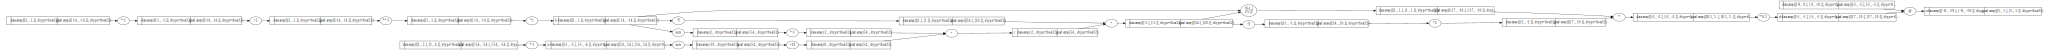

In [7]:
a = -Tensor([[1, 2], [3, 4]])
a.label = 'a'
a = a.sum()
b = 1/(2-Tensor([[1, 1]]))
b.label = 'b'
c = 10+a - b.sum()
c.label = 'c'
c += b.T
d = 2*c.T * (b ** c)/2
d.label = 'd'

e = d @ Tensor([[8, 9], [0, 10]])
e.label = 'e'

e.backward()
draw_graph(e)


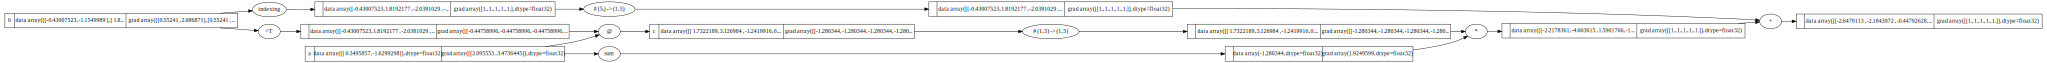

In [8]:
a = Tensor(np.random.randn(1, 2), label="a")
b = Tensor(np.random.randn(5, 2), label="b")
c = a @ b.T
c.label = "c"
c = c.reshape(1, 5) * a.sum(axis=None)
c += b[:, 0].reshape(1, -1)

c.backward()
draw_graph(c)


In [9]:
def relu(val: Tensor):
    res = Tensor(val.d.maximum(0, val.data), (val,), "ReLU", val.device)

    def backward():
        val.grad += (val.data > 0) * res.grad

    res._backward = backward
    return res


def tanh(val: Tensor):
    res = Tensor(val.d.tanh(val.data), (val,), "TanH", val.device)

    def backward():
        val.grad += (1 - res.data**2) * res.grad

    res._backward = backward
    return res


In [10]:
X = Tensor(np.array([[0, 0], [0, 1], [1, 0], [1, 1]]))  # (4, 2)
Y = Tensor(np.array([[0], [1], [1], [0]]))              # (4, 1)

n_in = 2
n_out = 1

W1 = Tensor(np.random.uniform(-1, 1, (n_in, 3))) # n_in, out
b1 = Tensor(np.random.uniform(-1, 1, (1, 3)))    # 1, out

W2 = Tensor(np.random.uniform(-1, 1, (3, n_out)))
b2 = Tensor(np.random.uniform(-1, 1, (1, n_out)))

yHat1 = X @ W1 + b1
yHat2 = yHat1 @ W2 + b2
yHat2.shape


(4, 1)

In [11]:
lr = .05

for i in range(400):
    
    # forward prop
    yHat1 = X @ W1 + b1
    yHat1 = tanh(yHat1)
    yHat2 = yHat1 @ W2 + b2
    
    # calc loss
    loss = ((Y - yHat2)**2).sum() / yHat2.shape[0]

    # zero_grad
    W1.grad *= 0
    b1.grad *= 0
    W2.grad *= 0
    b2.grad *= 0

    # backward prop
    loss.backward()

    # optimizer step
    W1.data -= lr * W1.grad
    b1.data -= lr * b1.grad
    W2.data -= lr * W2.grad
    b2.data -= lr * b2.grad

    # print loss
    if i % 40 == 0:
        print(loss)


tensor(1.0327251, dtype=float32)
tensor(0.22304286, dtype=float32)
tensor(0.20212203, dtype=float32)
tensor(0.17176789, dtype=float32)
tensor(0.13337973, dtype=float32)
tensor(0.09187082, dtype=float32)
tensor(0.05485466, dtype=float32)
tensor(0.02834029, dtype=float32)
tensor(0.01292706, dtype=float32)
tensor(0.00536713, dtype=float32)


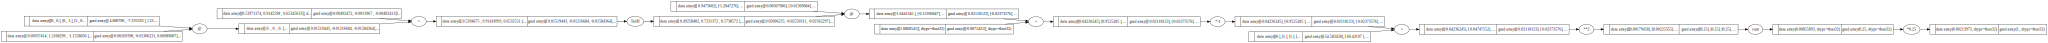

In [12]:
draw_graph(loss)

In [13]:
yHat1 = X @ W1 + b1
yHat1 = tanh(yHat1)
yHat2 = yHat1 @ W2 + b2

[np.round(p.data) for p in yHat2.reshape(-1)]


[0.0, 1.0, 1.0, 0.0]

In [14]:
class ModuleList:
    def __init__(self, modules):
        self.modules = modules

    def __getitem__(self, indices):
        return self.modules[indices]

class Module:
    def __init__(self, device: str):
        self.d, self.device = get_d__(device)

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        parameters = []

        for _, val in self.__dict__.items():
            if isinstance(val, Tensor):
                parameters.append(val)
            elif isinstance(val, ModuleList):
                for v in val:
                    parameters += v.parameters()
            elif isinstance(val, Linear):
                parameters += val.parameters()

        return parameters

    def to(self, device: str):
        if device == self.device:
            return self

        self.d, self.device = get_d__(device)

        for tensor in self.parameters():
            tensor.to(device)


class Linear(Module):
    def __init__(self, in_features, out_features, bias=True, device="cpu"):
        super().__init__(device)
        self.bias = bias
        self.W = Tensor(self.d.random.uniform(-1, 1, (in_features, out_features)), device=device)
        if self.bias:
            self.b = Tensor(self.d.random.uniform(-1, 1, (1, out_features)), device=device)

    def __call__(self, X: Tensor):
        out = X @ self.W + self.b
        return out


In [15]:
X = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])  # (4, 2)
Y = Tensor([[0], [1], [1], [0]])  # (4, 1)


class Model(Module):
    def __init__(self, n_in, n_out):
        self.l1 = Linear(n_in, 3)
        self.l2 = Linear(3, n_out)

    def __call__(self, x):
        x = tanh(self.l1(x))
        x = self.l2(x)
        return x


model = Model(2, 1)
model(X).shape


(4, 1)

In [16]:
lr = 0.1
n_epochs = 400

for epoch_i in range(n_epochs):
    # forward prop
    yHat = model(X)

    loss = sum((yHat - Y)**2) / yHat.shape[0]

    model.zero_grad()
    loss.backward()

    # optimizer.step()
    for p in model.parameters():
        p.data = p.data - lr * p.grad

    if epoch_i % 40 == 0:
        print(loss)


tensor([1.4146348], dtype=float32)
tensor([0.2553319], dtype=float32)
tensor([0.23856339], dtype=float32)
tensor([0.21275342], dtype=float32)
tensor([0.1547976], dtype=float32)


tensor([0.07133514], dtype=float32)
tensor([0.01771741], dtype=float32)
tensor([0.00279793], dtype=float32)
tensor([0.00035827], dtype=float32)
tensor([4.240375e-05], dtype=float32)


In [17]:
[np.round(p.data) for p in model(X).reshape(-1)]


[0.0, 1.0, 1.0, 0.0]